In [1]:
import numpy as np
from utils import annotated_heatmap

# Corridor environment
We create here the corridor environment. The number of cells/states in the corridor is set by default to 3 but it can be changed when the class is instantiated.

In [4]:
class CorridorEnv:
    def __init__(self, n_states=3, is_slippery = False):
        self.nS = n_states
        self.nA = 3
        self.is_slippery = is_slippery
        self.s = 0
        self.prob = 0.9
        self.terminal_s = self.nS-1        
        self.model = {}
        for s in range(self.nS):
            self.model[s] = {}
            for a in range(self.nA):
                self.s = s
                s_, dropped = self.step(a)
                p1 = self.prob
                p2 = 1 - self.prob
                r = -10 if dropped else -1 
                d = bool(s == self.terminal_s)
                self.model[s][a] = [(p1, s_, r, d), (p2, np.int64(s), r, d)] if self.is_slippery else [(1.0, s_, r, d)]
        
        
    def reset(self):
        self.s = 0
        
    def step(self, a):
        if a == 0: # LEFT
            shift = -1
        elif a == 1: # DON'T MOVE
            shift = 0
        elif a == 2:
            shift = +1 # RIGHT
        else:
            raise

        if self.is_slippery:
            self.s = np.random.choice([self.s+shift, self.s], p=[self.prob, 1 - self.prob])
        else:
            self.s += shift
            
        dropped = (self.s<0 or self.s>=self.nS)
        return np.clip(self.s, 0, self.nS-1), dropped

We define an instance of the corridor environment of 5 states, with the slip flag to False. 

In [5]:
env = CorridorEnv(n_states=5, is_slippery=False)

n_states = env.nS
n_actions = env.nA

gamma = 1.0

# Policy Evaluation
Policy evalutation is the process of assessing the quality of a given policy. For a fixed policy, the output of this is the value function V. This could be achieved by rolling out a full episode and assigning a value to all the visited states backwards from the terminal state (Monte-Carlo approach). In RL, however, it is standard practice to use the Bellman equation as an online update rule (bootstrapping) so we don't have to wait until the end of an episode to evaluate the policy in a given state.

In [11]:
def bellman_update(V, pi, s, transitions):
    value = 0
    for a in range(n_actions):
        for p, s_, r, done in transitions[s][a]:
            value += pi[s][a]*p*(r + gamma*(V[s_]))*(not done)
    V[s] = value
    
def policy_evaluation(V, policy, transitions):
    step = 0
    while True:
        V_prev = V.copy()
        for s in range(n_states):
            bellman_update(V, policy, s, transitions)
            
        d = max(abs(V-V_prev))
        if d < 0.01:
            break
        step += 1
    return V, step

# Policy Improvement
Once a policy has been evaluated, we can improve it. The improvement is achieved by picking, at every state, the action that yields the highest state-action value (in a greedy fashion), according to the latest evaluation.

In [12]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item 
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top_value = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value update top and reset ties to zero
        # if a value is equal to top value add the index to ties
        # return a random selection from ties.
        if q_values[i] > top_value:
            top_value = q_values[i]
            ties = [i]
        elif q_values[i] == top_value:
            ties.append(i)
    return np.random.choice(ties)

def greedify_policy(V, pi, s, transitions):
    q = np.zeros(n_actions)
    for a in range(n_actions):
        for p, s_, r, done in transitions[s][a]:
            q[a] += p*(r + gamma*V[s_])*(not done)
    a_max = argmax(q)
    pi[s] = np.zeros(n_actions)
    pi[s][a_max] = 1.0

def policy_improvement(pi, V, transitions):
    policy_stable = True
    for s in range(n_states):
        old_pi = pi[s].copy()
        greedify_policy(V, pi, s, transitions)
        if not np.array_equal(old_pi, pi[s]):
            policy_stable = False
    return policy_stable        

Policy evaluation and improvement can be performed recursively until both the policy and the value function converge to their optimal values. The way these two steps are alternated is not unique: one can chose to perform a complete evaluation and a complete improvement  (for every visited state) at every step of the recursion. We refer to this approach as policy iteration. Alternatively, one can just complete limited number of evaluation and steps. When we only perform a single evaluation and a single improvement update (for a single state) we talk about value iteration. 

Both approaches will eventually converge, although Value Iteration usually converges faster (as can be seen in the examples below).

# Policy Iteration

In [13]:
def policy_iteration():
    P_model = env.model
    V = np.zeros(n_states)
    pi = [np.ones(n_actions)/n_actions]*n_states # Set the policy to a uniform distribution
    policy_converged = False
    steps = 0
    while not policy_converged:
        V, steps_eval = policy_evaluation(V, pi, P_model)
        steps += steps_eval
        policy_converged = policy_improvement(pi, V, P_model)
    return V, pi, steps

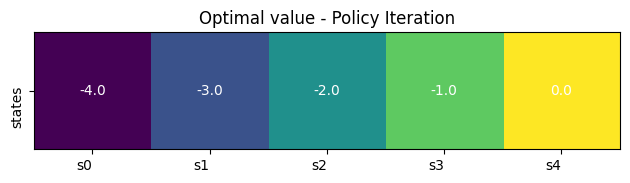

Optimal policy
s0: [0. 0. 1.]
s1: [0. 0. 1.]
s2: [0. 0. 1.]
s3: [0. 0. 1.]
s4: [0. 1. 0.]
Steps to convergence 112


In [15]:
V, pi, steps_pi = policy_iteration()
annotated_heatmap([V], "Optimal value - Policy Iteration")
print("Optimal policy")
for s, actions in enumerate(pi):
    print("s"+str(s)+":", actions)
print("Steps to convergence", steps_pi)

# Value Iteration

In [24]:
def value_iteration():
    P_model = env.model
    V = np.zeros(n_states)
    pi = [np.ones(n_actions)/n_actions]*n_states # Set the policy to a uniform distribution
    steps_vi = 0
    while True:
        V_prev = V.copy()
        for s in range(n_states):
            bellman_update(V, pi, s, P_model)
            greedify_policy(V, pi, s, P_model)
        d = max(abs(V-V_prev))
        if d < 0.01:
            break
        steps_vi +=1
    return V, pi, steps_vi

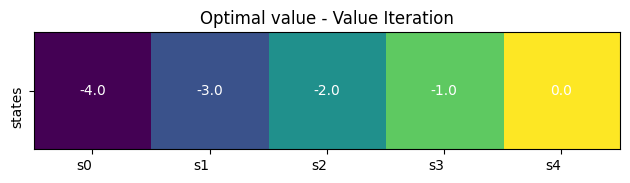

Optimal policy
s0: [0. 0. 1.]
s1: [0. 0. 1.]
s2: [0. 0. 1.]
s3: [0. 0. 1.]
s4: [1. 0. 0.]
Steps to convergence 5


In [25]:
V, pi, steps_vi = value_iteration()
annotated_heatmap([V], "Optimal value - Value Iteration")
print("Optimal policy")
for s, actions in enumerate(pi):
    print("s"+str(s)+":", actions)
print("Steps to convergence", steps_vi)

As you can see the Value Iteration converges much faster than Policy Iteration. Feel free to test the convergence properties of both algorithms in more complex scenarios, such as when the floor of the corridor is slippery ``CorridorEnv(is_slippery=True)``

# Bellman Optimality Equation
We show here below that performing a single step of policy evaluation and improvement at each step corresponds to simply applying the Bellman Optimality equation (as opposed to the Bellman equation). As a matter of fact, both approaches consists in updating the value function based on the greedy policy (i.e. the policy that achieves the highest immediate return).

In [26]:
def bellman_optimality_update(V, pi, s, transitions):
    q = np.zeros(n_actions)
    for a in range(n_actions):
        value = 0
        for p, s_, r, done in transitions[s][a]:
            value += p*(r + gamma*(V[s_]))*(not done)
        q[a] = value
    V[s] = max(q)
    
def value_iteration_w_bellman_optimality():
    P_model = env.model
    V = np.zeros(n_states)
    pi = [np.ones(n_actions)/n_actions]*n_states # Set the policy to a uniform distribution
    steps = 0
    while True:
        V_prev = V.copy()
        for s in range(n_states):
            bellman_optimality_update(V, pi, s, P_model)
            
        d = max(abs(V-V_prev))
        if d < 1:
            break
        steps +=1
        
    for s in range(n_states):
        greedify_policy(V, pi, s, P_model)
    return V, pi, steps

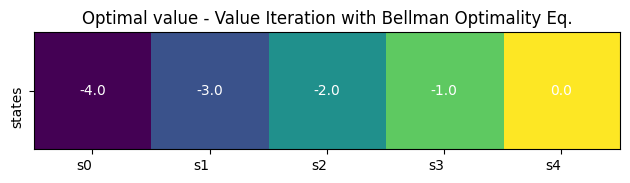

Optimal policy
s0: [0. 0. 1.]
s1: [0. 0. 1.]
s2: [0. 0. 1.]
s3: [0. 0. 1.]
s4: [1. 0. 0.]
Steps to convergence 4


In [23]:
V, pi, steps_vi = value_iteration_w_bellman_optimality()
annotated_heatmap([V], "Optimal value - Value Iteration with Bellman Optimality Eq.")
print("Optimal policy")
for s, actions in enumerate(pi):
    print("s"+str(s)+":", actions)
print("Steps to convergence", steps_vi)